Credit: https://wmathor.com/index.php/archives/1451/

#Sequence to Sequence model with Attention

###Special Tokens
First we define tokens within our sentences that aren't really words. Examples include padding to make all the sentences the appropriate length for our model, the beginnign and end of sentence tokens, and tokens that indicate characters that we don't really know. 

###Dictionary of occurences
Then we create a dictionary that maps each of these tokens to a number. We also define a count dictionary that keeps track of the number of occurences of each token/word. For example, the "fit" function takes in a sentence and adds to the number of occurences within the dictionary. 

###Cutting down this dictionary
To trim down this dictionary, we remove words that have either too little occurences or too many occurences. Also, if there is a maximum vocabulary size we can fit into our dictionary, we sort the dictionary based on number of occurences and we take the words that occur most. We also remove any special tokens from this word dictionary. 

###Transforming a list of words using our dictionary
For transforming a list of words into a preprocessed list of numbers, if the sentence is smaller than the required length we add padding to the sentence (the pad token) in the front of the back depending on preference. If its greater, we truncate it by cutting off either the last few words or the first few words. Finally, for any word that isn't in our dictionary, we replace with an unknown token. 

To go from a list of numbers to a list of words, simply reverse the process by using the reverse dictionary. 

In [ ]:
class Word2Sequence:
    PAD_TAG = "<PAD>" # Padding Token
    SOS_TAG = "<SOS>" # Start Of Sentence Token
    EOS_TAG = "<EOS>" # End Of Sentence Token
    UNK_TAG = "<UNK>" # Unknown Token

    PAD = 0
    SOS = 1
    EOS = 2
    UNK = 3
    
    special_tokens = [PAD_TAG, SOS_TAG, EOS_TAG, UNK_TAG]
        
    def __init__(self, custom_dict = None):
        self.dict = {
            self.PAD_TAG : self.PAD,
            self.SOS_TAG : self.SOS,
            self.EOS_TAG : self.EOS,
            self.UNK_TAG : self.UNK
        } if custom_dict == None else custom_dict
        
        self.count = {}

    def fit(self, sentence):
        """save words in sentence to self.dict
        param: sentence: [word1, word2, word3...]
        """
        for word in sentence:
            self.count[word] = self.count.get(word, 0) + 1

    def build_vocab(self, min=5, max=None, max_features=None):
        """
        build self.dict and reverse_dict
        param min:          least occurrance of word to be considered
        param max:          max occurrance of word to be considered
        param max_features: max vocab size for tokenizer
        returns:            
        """
        # Delete words in count whose word frequency is less than min
        if min is not None:
            self.count = {word: value for word,value in self.count.items() if value > min}
        # Delete the value with the number of times greater than max
        if max is not None:
            self.count = {word: value for word,value in self.count.items if value < max}
        # Limit the number of reserved words
        if max_features is not None:
            temp = sorted(self.count.items(), key=lambda x:x[-1], reverse=True)[:max_features]
            self.count = dict(temp)

        for word in self.count:
            if word not in self.special_tokens:
                self.dict[word] = len(self.dict)
        
        # reversed self.dict
        self.reverse_dict = dict(zip(self.dict.values(), self.dict.keys()))
    
    def transform(self, sentence, max_len=None, pad_first=False):
        """
        convert setence to int sequence
        param sentence: [word1, word2...]
        param max_len: int, do padding or truncation
        """
        if max_len is not None: # do padding here
            if pad_first == False:
                if max_len > len(sentence):
                    sentence = sentence + [self.PAD_TAG] * (max_len-len(sentence))
                if max_len < len(sentence):
                    sentence = sentence[:max_len] #truncation
            else:
                if max_len > len(sentence):
                    sentence = [self.PAD_TAG] * (max_len-len(sentence)) + sentence
                if max_len < len(sentence):
                    sentence = sentence[-max_len:] #truncation

        return [self.dict.get(word, self.UNK) for word in sentence]
    
    def inverse_transform(self, indices, is_tensor=False):
        """
        convert int sequences to words
        param indices: [1, 2, 3, 4, 5...]
        """
        if is_tensor == False:
            return [self.reverse_dict.get(idx) for idx in indices]
        
        else:
            
            return [self.reverse_dict.get(idx.item()) for idx in indices]

    def __len__(self):
        return (len(self.dict))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import numpy as np
import random
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# read small_en-cn.txt file
data_path = '/content/drive/MyDrive/NLP Curriculum/eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist()#english sentences
target_texts = df.chinese.values.tolist()#chinese sentences

##Tokenization
For every setence in english, we tokenize it using nltk. Tokenization splits a sentence into its words. For example, the sentence "NLP is fun" is split into the tokens ["nlp", "is", "fun"]. For chinese, we just split each sentence into its corresponding characters. 

In [ ]:
tk = WordPunctTokenizer()
# limit = 100 # IF model computation is still a burden
# english = [tk.tokenize(sentence.lower()) for sentence in input_texts][:limit]
# chinese = [[x for x in sentence] for sentence in target_texts][:limit]
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]

Using the Word2Sequence class we created above, we two of these for english and chinese. We add the english words to the vocab of the english class and the chinese characters to the vocab of the chinese words. 

In [ ]:
inp_tk = Word2Sequence()
for words in english:
    inp_tk.fit(words)
inp_tk.build_vocab(min=0, max_features=None)

oup_tk = Word2Sequence()
for words in chinese:
    oup_tk.fit(words)
oup_tk.build_vocab(min=0, max_features=None)

print(f"Total English Words in our input tokenizer: {len(inp_tk.dict)}")
print(f"Total Chinese chars in our output tokenizer: {len(oup_tk.dict)}")

We create a dataset class to hold the key fields for our dataset. There is a the max input length and output length of each sequence. We have all the english and chinese sentences. We finally have the input and output tokenizers which convert the word lists to numbers. 

For functions, the get item function gets one sentence upto the maximum length allowed. We add an end of sentence character to each sentence to wrap it up. If the sentence has a smaller length then the maximum length, we pad it with extra tokens. 

In [ ]:
class Dataset(Dataset):
  def __init__(self, X, Y, in_tknz, out_tknz, in_maxlen, out_maxlen):
    self.in_maxlen = in_maxlen
    self.out_maxlen = out_maxlen
    
    self.X = X # english sentences
    self.Y = Y # chinese sentences
    
    self.in_tknz = in_tknz # input tokenizer for english
    self.out_tknz = out_tknz # output tokenizer for chinese
  
  def __getitem__(self, idx):
    # -1 because we stil have to concate the <SOS> and <EOS> tokens
    enc_in = self.X[idx][:self.in_maxlen-1]
    enc_in = enc_in + ["<EOS>"]
    
    dec_out = self.Y[idx][:self.out_maxlen-1]
    dec_out = dec_out + ["<EOS>"]
    
    # Convert enc_in, dec_in, dec_out to 1D integers
    enc_in = self.in_tknz.transform(enc_in, max_len=self.in_maxlen, pad_first=False)
    dec_out = self.out_tknz.transform(dec_out, max_len=self.out_maxlen, pad_first=False)

    return enc_in, dec_out

  def __len__(self):
    # Returns number of data in this dataset
    return len(self.X)

# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
#       we can convert data into Long Tensors Here
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_out]， [enc_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader

In [ ]:
# NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 
# 1. <SOS>, word1, word2, word3, ..., <EOS>
# 2. word1, word2, word3, ..., <EOS> 
# 3. word1, word2, word3, ...

# NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):
# Decoder Input: <SOS>, word1, word2, word3, ...
# Decoder Output: word1, word2, word3, ..., <EOS> 

In [ ]:
eng_maxlen = 26 # 25 + 1(<EOS> token)
chin_maxlen = 40 # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1 # Seq2Seq is very ram consuming, we have to keep batch_size low

# Get PyTorch Dataset
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = inp_tk, out_tknz = oup_tk,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)

In [ ]:
# Seq2Seq Paarameters
in_maxlen = 26 # 25 + 1(<EOS> token)
out_maxlen = 40 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 384 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(inp_tk.dict) # OR... vocab size of englisth -> 600
dec_n_class = len(oup_tk.dict) # OR... vocab size of chinese -> 667
batch_size = 1

<h1>New Code</h1>

The model
Note: GRU is a sister variant of LSTM, just that GRU only has one h_0 while LSTM has both cell and h_0

The new format with attention: hn is an attention vector

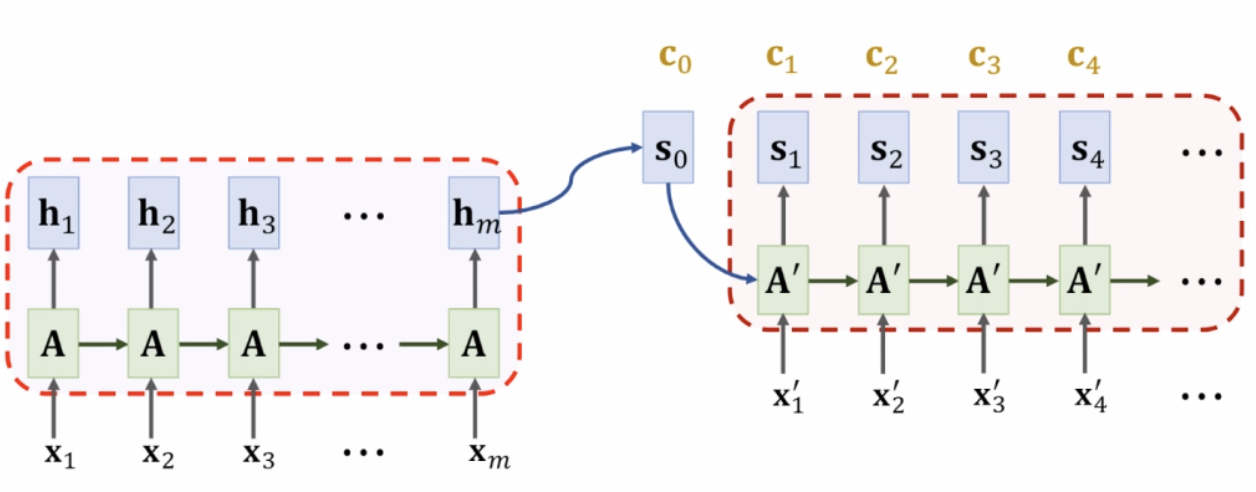

<h1>Implementing attention</h1>

Attention tells the encoder and decoder what to pay attention to while translating

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim,
                 bidirectional=False):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim) + dec_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, s, enc_output):
        
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim]
        
        batch_size = enc_output.shape[1]
        src_len = enc_output.shape[0]
        
        # repeat decoder hidden state src_len times
        # s = [batch_size, src_len, dec_hid_dim]
        # enc_output = [batch_size, src_len, enc_hid_dim]
        s = s.unsqueeze(1).repeat(1, src_len, 1)
        enc_output = enc_output.transpose(0, 1)
        
        # energy = [batch_size, src_len, dec_hid_dim]
        energy = torch.tanh(self.attn(torch.cat((s, enc_output), dim = 2)))
        
        # attention = [batch_size, src_len]
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

<h1>Assembling the model</h1>

an encoder is the starting part of our model. It creates readable vectors from the ids, then sends them to the decoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src): 
        '''
        src = [src_len, batch_size]
        '''
        src = src.transpose(0, 1) # src = [batch_size, src_len]
        embedded = self.dropout(self.embedding(src)).transpose(0, 1) # embedded = [src_len, batch_size, emb_dim]
        
        # enc_output = [src_len, batch_size, hid_dim]
        # enc_hidden = [n_layers, batch_size, hid_dim]
        enc_output, enc_hidden = self.rnn(embedded) # if h_0 is not give, it will be set 0 acquiescently

        # enc_hidden is stacked [forward_1, forward_2, forward_3, ...]
        # enc_output are always from the last layer
        
        # enc_hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state
        # encoder RNNs fed through a linear layer
        # s = [batch_size, dec_hid_dim]
        s = torch.tanh(enc_hidden[-1,:,:])
        
        return enc_output, s

A decoder is the end part of our model. It takes the machine-readable meaning-vectors and transforms them into the second language

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention,
                 bidirectional=False):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, dec_input, s, enc_output):
             
        # dec_input = [batch_size]
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim]
        
        dec_input = dec_input.unsqueeze(1) # dec_input = [batch_size, 1]
        
        embedded = self.dropout(self.embedding(dec_input)).transpose(0, 1) # embedded = [1, batch_size, emb_dim]
        
        # a = [batch_size, 1, src_len]  
        a = self.attention(s, enc_output).unsqueeze(1)
        
        # enc_output = [batch_size, src_len, enc_hid_dim]
        enc_output = enc_output.transpose(0, 1)

        # c = [1, batch_size, enc_hid_dim]
        c = torch.bmm(a, enc_output).transpose(0, 1)

        # rnn_input = [1, batch_size, enc_hid_dim + emb_dim]
        rnn_input = torch.cat((embedded, c), dim = 2)
            
        # dec_output = [src_len(=1), batch_size, dec_hid_dim]
        # dec_hidden = [n_layers, batch_size, dec_hid_dim]
        dec_output, dec_hidden = self.rnn(rnn_input, s.unsqueeze(0))
        
        # embedded = [batch_size, emb_dim]
        # dec_output = [batch_size, dec_hid_dim]
        # c = [batch_size, enc_hid_dim]
        embedded = embedded.squeeze(0)
        dec_output = dec_output.squeeze(0)
        c = c.squeeze(0)
        
        # pred = [batch_size, output_dim]
        pred = self.fc_out(torch.cat((dec_output, c, embedded), dim = 1))
        
        return pred, dec_hidden.squeeze(0)

This assembles both the encoder and decoder into one easy-to-use object

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src_len, batch_size]
        # trg = [trg_len, batch_size]
        # teacher_forcing_ratio is probability to use teacher forcing
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # enc_output is all hidden states of the input sequence, back and forwards
        # s is the final forward and backward hidden states, passed through a linear layer
        enc_output, s = self.encoder(src)
                
        # first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        
        for t in range(1, trg_len):
            
            # insert dec_input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            dec_output, s = self.decoder(dec_input, s, enc_output)
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = dec_output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = dec_output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            dec_input = trg[t] if teacher_force else top1

        return outputs

Creating the object

In [ ]:
INPUT_DIM = len(inp_tk.dict) # vocab_size for english
OUTPUT_DIM = len(oup_tk.dict) # vocab_size for chinese
ENC_EMB_DIM = 384
DEC_EMB_DIM = 384
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)
# # NOTE: Uncomment this if loading pretrained model
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))
criterion = nn.CrossEntropyLoss(ignore_index = inp_tk.dict["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

<h1>Training Our Model</h1>

In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()    
    epoch_loss = 0
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader.dataset)/1):
        src = batch[0].permute(1,0) # src = [src_len, batch_size]
        trg = batch[2].permute(1,0) # trg = [trg_len, batch_size]
        src, trg = src.to(device), trg.to(device)
        # pred = [trg_len, batch_size, pred_dim]
        pred = model(src, trg)
        
        pred_dim = pred.shape[-1]
        
        # trg = [(trg len - 1) * batch size]
        # pred = [(trg len - 1) * batch size, pred_dim]
        trg = trg[1:].view(-1)
        pred = pred[1:].view(-1, pred_dim)
        
        loss = criterion(pred, trg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
  
    return epoch_loss / len(dataloader.dataset)

assessing the model

In [ ]:
loss_records = []
for epoch in range(100):
    train_loss = train(model, dataloader, optimizer, criterion)
    loss_records.append(train_loss)
    torch.save(model.state_dict(), 'seq2seq.pt')
    print(f'\tEpoch: {epoch} Train Loss: {train_loss:.3f}')

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
showPlot(loss_records)

<h1>Using Our Model</h1>

In [ ]:
def translate(eng_sent, model, device):
    # processes the inputs
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = inp_tk.transform(eng_sent, max_len=26, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*40)[:40]
    dec_in = oup_tk.transform(dec_in, max_len=40, pad_first=False)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)
    src = eng_sent.unsqueeze(1)
    trg = dec_in.unsqueeze(1)
    # runs the model and returns the output
    src, trg = src.to(device), trg.to(device)
    pred = model(src, trg, teacher_forcing_ratio=-1) # avoid teacher_forcing_ratio by setting negative
    pred_dim = pred.shape[-1]
    pred = pred[0:].view(-1, pred_dim)
    return pred

In [ ]:
import random
eng_sents = random.sample(input_texts, 5)
for sent in eng_sents:
  pred = translate(sent, model, device)
  pred = [pred.topk(1)[1].item() for pred in pred]
  print(sent)
  # turns model output into words
  print("".join([word for word in oup_tk.inverse_transform(pred) if word != "<EOS>"and word != "<PAD>"]))
  print("\n")